# Cluster Analysis for Same Subject Trial (Batch 12 d and g)

## Pre-processing

In [1]:
## Import necessary libraries

import pandas as pd
import numpy as np
import openpyxl
from openpyxl import load_workbook
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from plotly.subplots import make_subplots
from datetime import datetime
from scipy import stats
import hdbscan
import umap
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import torch

In [2]:
## Initialize the data format

# Define new column names
new_column_names = [
    'Time', 'Hip x', 'Hip y', 'Hip likelihood',
    'Knee x', 'Knee y', 'Knee likelihood',
    'Ankle x', 'Ankle y', 'Ankle likelihood',
    'Heel (ventral) x', 'Heel (ventral) y', 'Heel (ventral) likelihood',
    'Instep (dorsal) x', 'Instep (dorsal) y', 'Instep (dorsal) likelihood',
    'Toe 1 (Proximal Thumb) x', 'Toe 1 (Proximal Thumb) y', 'Toe 1 (Proximal Thumb) likelihood',
    'Toe2 x', 'Toe2 y', 'Toe2 likelihood',
    'Toe 3 (Middle) x', 'Toe 3 (Middle) y', 'Toe 3 (Middle) likelihood',
    'Toe4 x', 'Toe4 y', 'Toe4 likelihood',
    'Toe 5 (Distal Pinky) x', 'Toe 5 (Distal Pinky) y', 'Toe 5 (Distal Pinky) likelihood',
]

# Function to process each file to have the right column names and normalize the x and y coordinates
def process_file(file_path):
    # Read only the first row to check column names
    df_header = pd.read_csv(file_path, nrows=0)
    
    # Check if the existing column names match the desired new column names
    if list(df_header.columns) != new_column_names:
        # If they don't match, read the file skipping metadata and assign new column names
        df = pd.read_csv(file_path, skiprows=3, header=None)
        df.columns = new_column_names
    else:
        # If they match, read the file normally
        df = pd.read_csv(file_path)
    
    # Further processing such as interpolating NA values and resetting index
    # df.dropna(inplace=True)
    df.interpolate(method='linear', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Remove rows with any zero values in coordinate columns
    coordinate_columns = [col for col in df.columns if ' x' in col or ' y' in col]
    df = df[(df[coordinate_columns] != 0).all(axis=1)]

    # Normalize the x and y coordinates
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    # coordinate_columns = [col for col in df.columns if ' x' in col or ' y' in col]
    df[coordinate_columns] = scaler.fit_transform(df[coordinate_columns])
    
    # Extract x and y coordinates
    x_columns = [col for col in df.columns if ' x' in col]  
    y_columns = [col for col in df.columns if ' y' in col]

    # Create dataframes for x and y coordinates
    x_df = df[x_columns]
    y_df = df[y_columns]
    return x_df, y_df, df

## Biphasic Trial (Batch 12d)

In [3]:
## Import the Biphasic data from the CSV files

x_df_batch12d_BP4, y_df_batch12d_BP4, df_batch12d_BP4 = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_12_csv/Batch 12d_(sideway_csv)/MATLAB BP Column 4-1726864393DLC_resnet50_batch_12_sidewayOct3shuffle1_150000_filtered.csv')
x_df_batch12d_BP5, y_df_batch12d_BP5, df_batch12d_BP5 = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_12_csv/Batch 12d_(sideway_csv)/MATLAB BP Column 5-1726864538DLC_resnet50_batch_12_sidewayOct3shuffle1_150000_filtered.csv')

x_df_batch12d_TT4, y_df_batch12d_TT4, df_batch12d_TT4 = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_12_csv/Batch 12d_(sideway_csv)/MATLAB TT Column 4-1726864279DLC_resnet50_batch_12_sidewayOct3shuffle1_150000_filtered.csv')
x_df_batch12d_TT5, y_df_batch12d_TT5, df_batch12d_TT5 = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_12_csv/Batch 12d_(sideway_csv)/MATLAB TT Column 5-1726864437DLC_resnet50_batch_12_sidewayOct3shuffle1_150000_filtered.csv')

x_df_batch12d_TL4, y_df_batch12d_TL4, df_batch12d_TL4 = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_12_csv/Batch 12d_(sideway_csv)/MATLAB TL Column 4-1726864321DLC_resnet50_batch_12_sidewayOct3shuffle1_150000_filtered.csv')
x_df_batch12d_TL5, y_df_batch12d_TL5, df_batch12d_TL5 = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_12_csv/Batch 12d_(sideway_csv)/MATLAB TL Column 5-1726864468DLC_resnet50_batch_12_sidewayOct3shuffle1_150000_filtered.csv')

In [4]:
## Label Biphasic rows 

def assign_config_labels(df, prefix):
    n = len(df)
    section_size = n // 8
    labels = []
    for i in range(8):
        # For the last section, include all remaining rows
        if i == 7:
            end = n
        else:
            end = (i + 1) * section_size
        start = i * section_size
        labels.extend([f"{prefix} config {i+1}"] * (end - start))
    df['Actual Label (Configuration)'] = labels
    return df

# Apply to each DataFrame
df_batch12d_BP4 = assign_config_labels(df_batch12d_BP4, "BP4")
df_batch12d_BP5 = assign_config_labels(df_batch12d_BP5, "BP5")
df_batch12d_TL4 = assign_config_labels(df_batch12d_TL4, "TL4")
df_batch12d_TL5 = assign_config_labels(df_batch12d_TL5, "TL5")
df_batch12d_TT4 = assign_config_labels(df_batch12d_TT4, "TT4")
df_batch12d_TT5 = assign_config_labels(df_batch12d_TT5, "TT5")

# Optional: Check the label distribution
print(df_batch12d_BP4['Actual Label (Configuration)'].value_counts())
print(df_batch12d_BP5['Actual Label (Configuration)'].value_counts())
print(df_batch12d_TL4['Actual Label (Configuration)'].value_counts())
print(df_batch12d_TL5['Actual Label (Configuration)'].value_counts())
print(df_batch12d_TT4['Actual Label (Configuration)'].value_counts())
print(df_batch12d_TT5['Actual Label (Configuration)'].value_counts())


Actual Label (Configuration)
BP4 config 8    91
BP4 config 1    89
BP4 config 2    89
BP4 config 3    89
BP4 config 4    89
BP4 config 5    89
BP4 config 6    89
BP4 config 7    89
Name: count, dtype: int64
Actual Label (Configuration)
BP5 config 8    100
BP5 config 1     94
BP5 config 2     94
BP5 config 3     94
BP5 config 4     94
BP5 config 5     94
BP5 config 6     94
BP5 config 7     94
Name: count, dtype: int64
Actual Label (Configuration)
TL4 config 8    132
TL4 config 1    130
TL4 config 2    130
TL4 config 3    130
TL4 config 4    130
TL4 config 5    130
TL4 config 6    130
TL4 config 7    130
Name: count, dtype: int64
Actual Label (Configuration)
TL5 config 8    95
TL5 config 1    94
TL5 config 2    94
TL5 config 3    94
TL5 config 4    94
TL5 config 5    94
TL5 config 6    94
TL5 config 7    94
Name: count, dtype: int64
Actual Label (Configuration)
TT4 config 8    113
TT4 config 1    106
TT4 config 2    106
TT4 config 3    106
TT4 config 4    106
TT4 config 5    106
TT4 con

In [ ]:
# from IPython.display import display, HTML

# pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', None)

# html_table = df_batch12d_TT5.to_html(notebook=True, border=1, justify='center', table_id='scrollable-table', classes='scroll-table')
# display(HTML(f"""
# <style>
# #scrollable-table {{
#     border-collapse: collapse;
#     width: 100%;
# }}
# #scrollable-table th {{
#     position: sticky;
#     top: 0;
#     background: black;
#     color: white;
#     z-index: 2;
# }}
# #scrollable-table td:first-child,
# #scrollable-table th:first-child {{
#     background: black;
#     color: white;
# }}
# </style>
# <div style="max-height:400px; overflow:auto; border:1px solid #ccc;">
# {html_table}
# </div>
# """))


In [5]:
## Convert x,y pixel coordinates to displacement values

def calculate_euclidean_distances_per_row(x_df, y_df):
    distances = pd.DataFrame(index=x_df.index)
    for col in x_df.columns:
        y_col = col.replace(' x', ' y')
        if y_col in y_df.columns:
            distances[col.replace(' x', '')] = np.sqrt((x_df[col] - y_df[y_col]) ** 2)
    return distances

# Calculate the Euclidean distances per row for each dataset
df_BP4_disp = calculate_euclidean_distances_per_row(x_df_batch12d_BP4, y_df_batch12d_BP4)
df_BP5_disp = calculate_euclidean_distances_per_row(x_df_batch12d_BP5, y_df_batch12d_BP5)
df_TL4_disp = calculate_euclidean_distances_per_row(x_df_batch12d_TL4, y_df_batch12d_TL4)
df_TL5_disp = calculate_euclidean_distances_per_row(x_df_batch12d_TL5, y_df_batch12d_TL5)
df_TT4_disp = calculate_euclidean_distances_per_row(x_df_batch12d_TT4, y_df_batch12d_TT4)
df_TT5_disp = calculate_euclidean_distances_per_row(x_df_batch12d_TT5, y_df_batch12d_TT5)

# Combine and label all displacement DataFrames into one
df_biphasic_12d = pd.concat([
    df_BP4_disp.assign(Source='BP4', Config=df_batch12d_BP4['Actual Label (Configuration)'].values),
    df_BP5_disp.assign(Source='BP5', Config=df_batch12d_BP5['Actual Label (Configuration)'].values),
    df_TL4_disp.assign(Source='TL4', Config=df_batch12d_TL4['Actual Label (Configuration)'].values),
    df_TL5_disp.assign(Source='TL5', Config=df_batch12d_TL5['Actual Label (Configuration)'].values),
    df_TT4_disp.assign(Source='TT4', Config=df_batch12d_TT4['Actual Label (Configuration)'].values),
    df_TT5_disp.assign(Source='TT5', Config=df_batch12d_TT5['Actual Label (Configuration)'].values)
], ignore_index=True)

# Optional: Show the combined DataFrame
print(df_biphasic_12d.head())


        Hip      Knee     Ankle  Heel (ventral)  Instep (dorsal)  \
0  0.133728  0.306379  0.571372        0.017789         0.005187   
1  0.118520  0.407395  0.617578        0.034587         0.025655   
2  0.106007  0.486465  0.606850        0.136252         0.026837   
3  0.133509  0.492879  0.542645        0.126328         0.046991   
4  0.119892  0.492879  0.538048        0.126328         0.052282   

   Toe 1 (Proximal Thumb)      Toe2  Toe 3 (Middle)      Toe4  \
0                0.712968  0.243437        0.886980  0.962538   
1                0.714142  0.734593        0.890034  0.942741   
2                0.714142  0.735612        0.890034  0.930076   
3                0.713457  0.737051        0.866337  0.920101   
4                0.713180  0.737138        0.865793  0.903008   

   Toe 5 (Distal Pinky) Source        Config  
0              0.680917    BP4  BP4 config 1  
1              0.659738    BP4  BP4 config 1  
2              0.648903    BP4  BP4 config 1  
3           

In [6]:
## Perform UMAP dimensionality reduction

import umap

# Perform UMAP dimensionality reduction to 3 dimensions
umap_reducer = umap.UMAP(n_neighbors=113, min_dist=0, n_components=3, random_state=42)
umap_embedding = umap_reducer.fit_transform(df_biphasic_12d.drop(columns=['Source', 'Config'])) 

# # Perform HDBSCAN clustering
# hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=94, min_samples=90, cluster_selection_epsilon=0.5)
# hdbscan_labels = hdbscan_clusterer.fit_predict(umap_embedding)

# # Add the UMAP embedding and HDBSCAN labels to the dataframe
# df_biphasic_12d_umap_hdbscan = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])
# df_biphasic_12d_umap_hdbscan['Cluster'] = hdbscan_labels

# # Print the resulting dataframe
# print(df_biphasic_12d_umap_hdbscan)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [7]:
## Perform HDBSCAN clustering with hyperparameter tuning (grid search)

import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score

# True labels for evaluation (using your config labels)
true_labels = df_biphasic_12d['Config'].values

# Hyperparameter grids to try
min_cluster_sizes = [80, 94, 100, 113]
min_samples_list = [20, 50, 90]
cluster_selection_epsilons = [0.0, 0.2, 0.5]

results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        for epsilon in cluster_selection_epsilons:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                cluster_selection_epsilon=epsilon
            )
            labels = clusterer.fit_predict(umap_embedding)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            # Only score if more than 1 cluster and not all noise
            if n_clusters > 1 and np.any(labels != -1):
                sil = silhouette_score(umap_embedding[labels != -1], labels[labels != -1])
                ari = adjusted_rand_score(true_labels[labels != -1], labels[labels != -1])
                ami = adjusted_mutual_info_score(true_labels[labels != -1], labels[labels != -1])
            else:
                sil, ari, ami = np.nan, np.nan, np.nan
            results.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'epsilon': epsilon,
                'n_clusters': n_clusters,
                'silhouette': sil,
                'ARI': ari,
                'AMI': ami
            })

# Convert results to DataFrame and sort by AMI, silhouette, and closeness to 48 clusters
results_df = pd.DataFrame(results)
results_df['cluster_diff'] = (results_df['n_clusters'] - 48).abs()
results_df = results_df.sort_values(['AMI', 'silhouette', 'cluster_diff'], ascending=[False, False, True])

print(results_df[['min_cluster_size', 'min_samples', 'epsilon', 'n_clusters', 'silhouette', 'ARI', 'AMI']].head(10))

    min_cluster_size  min_samples  epsilon  n_clusters  silhouette       ARI  \
0                 80           20      0.0          11    0.680474  0.113899   
1                 80           20      0.2          11    0.680474  0.113899   
9                 94           20      0.0          10    0.714709  0.109146   
10                94           20      0.2          10    0.714709  0.109146   
18               100           20      0.0          10    0.714709  0.109146   
19               100           20      0.2          10    0.714709  0.109146   
27               113           20      0.0          10    0.714709  0.109146   
28               113           20      0.2          10    0.714709  0.109146   
2                 80           20      0.5           8    0.680269  0.109363   
11                94           20      0.5           7    0.713590  0.105211   

         AMI  
0   0.525630  
1   0.525630  
9   0.512812  
10  0.512812  
18  0.512812  
19  0.512812  
27  0.512812  

In [8]:
## Use the chosen optimal HDBSCAN parameters and add the UMAP-HDBSCAN results to a new DataFrame
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,
    min_samples=20,
    cluster_selection_epsilon=0.2
)
hdbscan_labels = hdbscan_clusterer.fit_predict(umap_embedding)

# Add the UMAP embedding HDBSCAN cluster, and Actual Config labels to the DataFrame
df_biphasic_12d_umap_hdbscan = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_biphasic_12d_umap_hdbscan['Cluster'] = hdbscan_labels
df_biphasic_12d_umap_hdbscan['Actual Label (Configuration)'] = df_biphasic_12d['Config'].values

In [9]:
# Calculate silhouette score
silhouette_avg = silhouette_score(df_biphasic_12d_umap_hdbscan[['UMAP1', 'UMAP2', 'UMAP3']], df_biphasic_12d_umap_hdbscan['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# Calculate adjusted rand index
ari = adjusted_rand_score(df_biphasic_12d_umap_hdbscan['Actual Label (Configuration)'], df_biphasic_12d_umap_hdbscan['Cluster'])
print(f'Adjusted Rand Index: {ari}')

# Calculate adjusted mutual information
ami = adjusted_mutual_info_score(df_biphasic_12d_umap_hdbscan['Actual Label (Configuration)'], df_biphasic_12d_umap_hdbscan['Cluster'])
print(f'Adjusted Mutual Information: {ami}')

Silhouette Score: 0.6559537649154663
Adjusted Rand Index: 0.11453530392490603
Adjusted Mutual Information: 0.522844446012109


In [ ]:
## Interactive visualization of the UMAP-HDBSCAN Clustering Results with Actual Config Labels

import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy.spatial import distance

# 3D scatter plot of UMAP-HDBSCAN clusters
fig = px.scatter_3d(
    df_biphasic_12d_umap_hdbscan,
    x='UMAP1', y='UMAP2', z='UMAP3',
    color=df_biphasic_12d_umap_hdbscan['Cluster'].astype(str),  # Ensure categorical coloring
    title='3D UMAP with HDBSCAN Clusters',
    opacity=0.7
)

# Calculate centroids for each actual configuration label
centroids = df_biphasic_12d_umap_hdbscan.groupby('Actual Label (Configuration)')[['UMAP1', 'UMAP2', 'UMAP3']].mean()

# Find the closest point to each centroid for annotation
for label, centroid in centroids.iterrows():
    distances = distance.cdist([centroid], df_biphasic_12d_umap_hdbscan[['UMAP1', 'UMAP2', 'UMAP3']])
    closest_point_index = np.argmin(distances)
    point = df_biphasic_12d_umap_hdbscan.iloc[closest_point_index]
    fig.add_trace(
        go.Scatter3d(
            x=[point['UMAP1']],
            y=[point['UMAP2']],
            z=[point['UMAP3']],
            mode='markers+text',
            marker=dict(size=5, color='black'),
            text=[str(label)],
            textposition='top center',
            textfont=dict(size=12, color='black'),
            showlegend=False
        )
    )

# Make the plot larger and axes labeled
fig.update_layout(
    width=1200,
    height=800,
    scene=dict(
        xaxis_title='UMAP1',
        yaxis_title='UMAP2',
        zaxis_title='UMAP3'
    )
)

fig.show()

In [10]:
# Change the label names so it's more visually appealing
df_biphasic_12d_umap_hdbscan['Actual Label (Configuration)'] = df_biphasic_12d_umap_hdbscan['Actual Label (Configuration)'].replace({
'BP4 config 1': 'BP 1',
    'BP4 config 2': 'BP 2',
    'BP4 config 3': 'BP 3',
    'BP4 config 4': 'BP 4',
    'BP4 config 5': 'BP 5',
    'BP4 config 6': 'BP 6',
    'BP4 config 7': 'BP 7',
    'BP4 config 8': 'BP 8',
    'BP5 config 1': 'BP 9',
    'BP5 config 2': 'BP 10',
    'BP5 config 3': 'BP 11',
    'BP5 config 4': 'BP 12',
    'BP5 config 5': 'BP 13',
    'BP5 config 6': 'BP 14',
    'BP5 config 7': 'BP 15',
    'BP5 config 8': 'BP 16',
    'TL4 config 1': 'TL 1',
    'TL4 config 2': 'TL 2',
    'TL4 config 3': 'TL 3',
    'TL4 config 4': 'TL 4',
    'TL4 config 5': 'TL 5',
    'TL4 config 6': 'TL 6',
    'TL4 config 7': 'TL 7',
    'TL4 config 8': 'TL 8',
    'TL5 config 1': 'TL 9',
    'TL5 config 2': 'TL 10',
    'TL5 config 3': 'TL 11',
    'TL5 config 4': 'TL 12',
    'TL5 config 5': 'TL 13',
    'TL5 config 6': 'TL 14',
    'TL5 config 7': 'TL 15',
    'TL5 config 8': 'TL 16',
    'TT4 config 1': 'TT 1',
    'TT4 config 2': 'TT 2',
    'TT4 config 3': 'TT 3',
    'TT4 config 4': 'TT 4',
    'TT4 config 5': 'TT 5',
    'TT4 config 6': 'TT 6',
    'TT4 config 7': 'TT 7',
    'TT4 config 8': 'TT 8',
    'TT5 config 1': 'TT 9',
    'TT5 config 2': 'TT 10',
    'TT5 config 3': 'TT 11',
    'TT5 config 4': 'TT 12',
    'TT5 config 5': 'TT 13',
    'TT5 config 6': 'TT 14',
    'TT5 config 7': 'TT 15',
    'TT5 config 8': 'TT 16',
})

35 [-0.82114611 -0.69500433]
38 [0.51219421 0.38051831]
10 [-0.64361481  0.97692067]
11 [-0.65777921  0.430968  ]
12 [-0.69885478  0.72236653]
13 [-0.22116684 -0.36061758]
14 [-0.02282576 -0.0801057 ]
27 [-0.70237071 -0.96766873]
25 [-0.53790646 -0.60537179]
28 [ 0.74705365 -0.32161253]


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


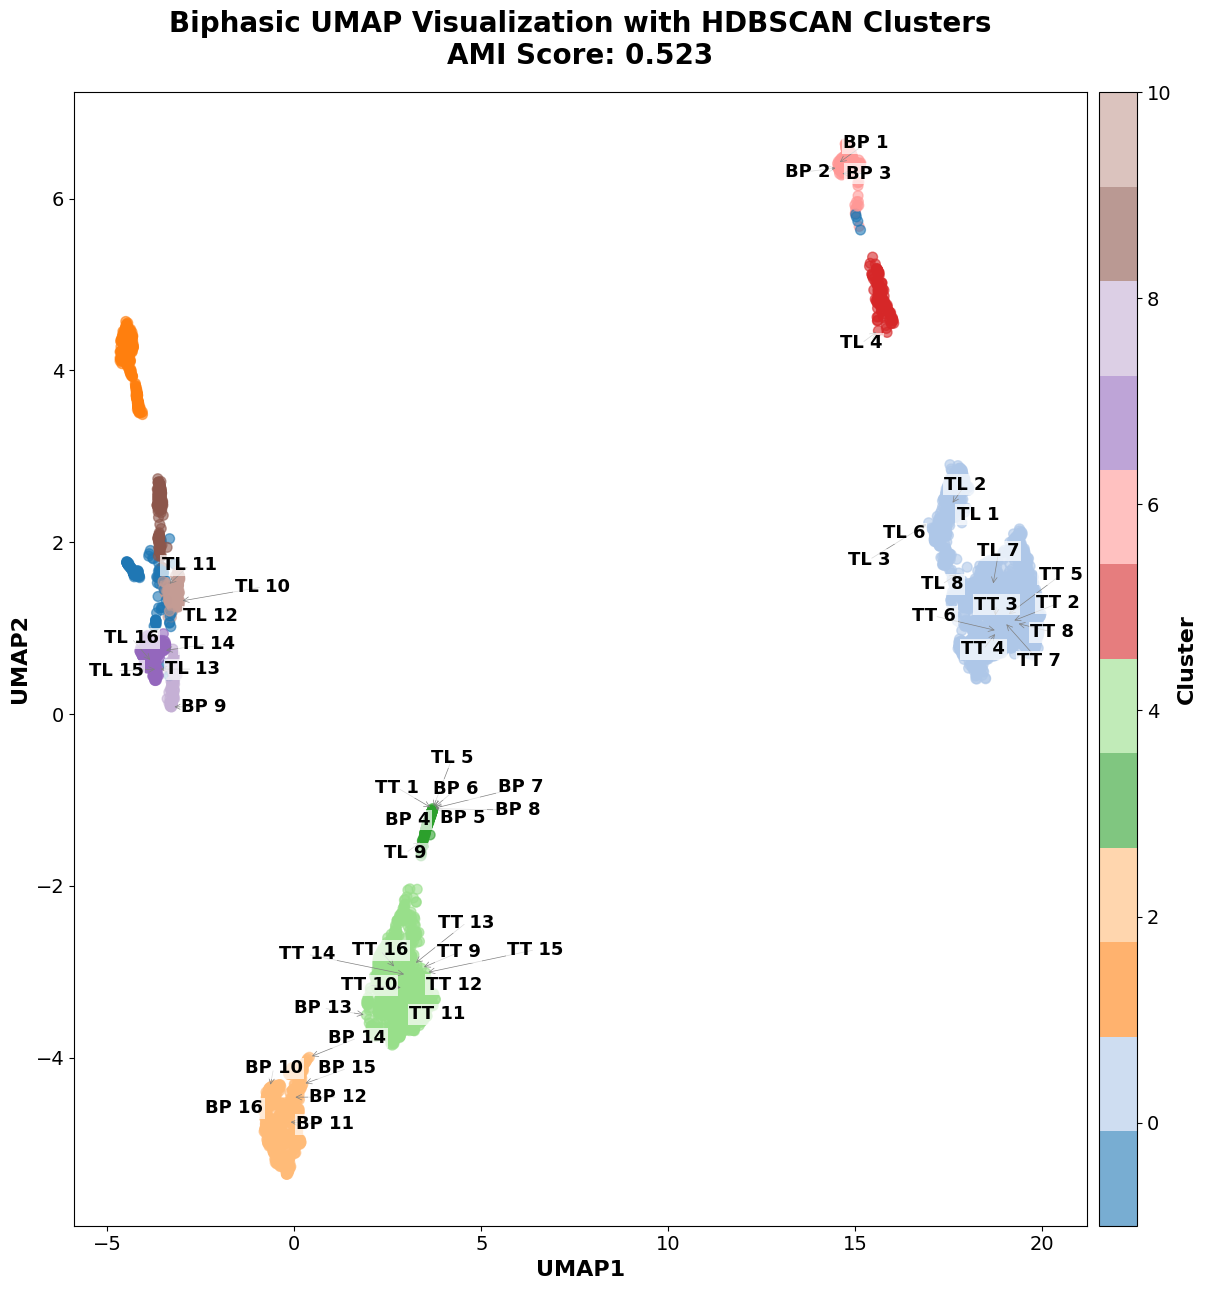

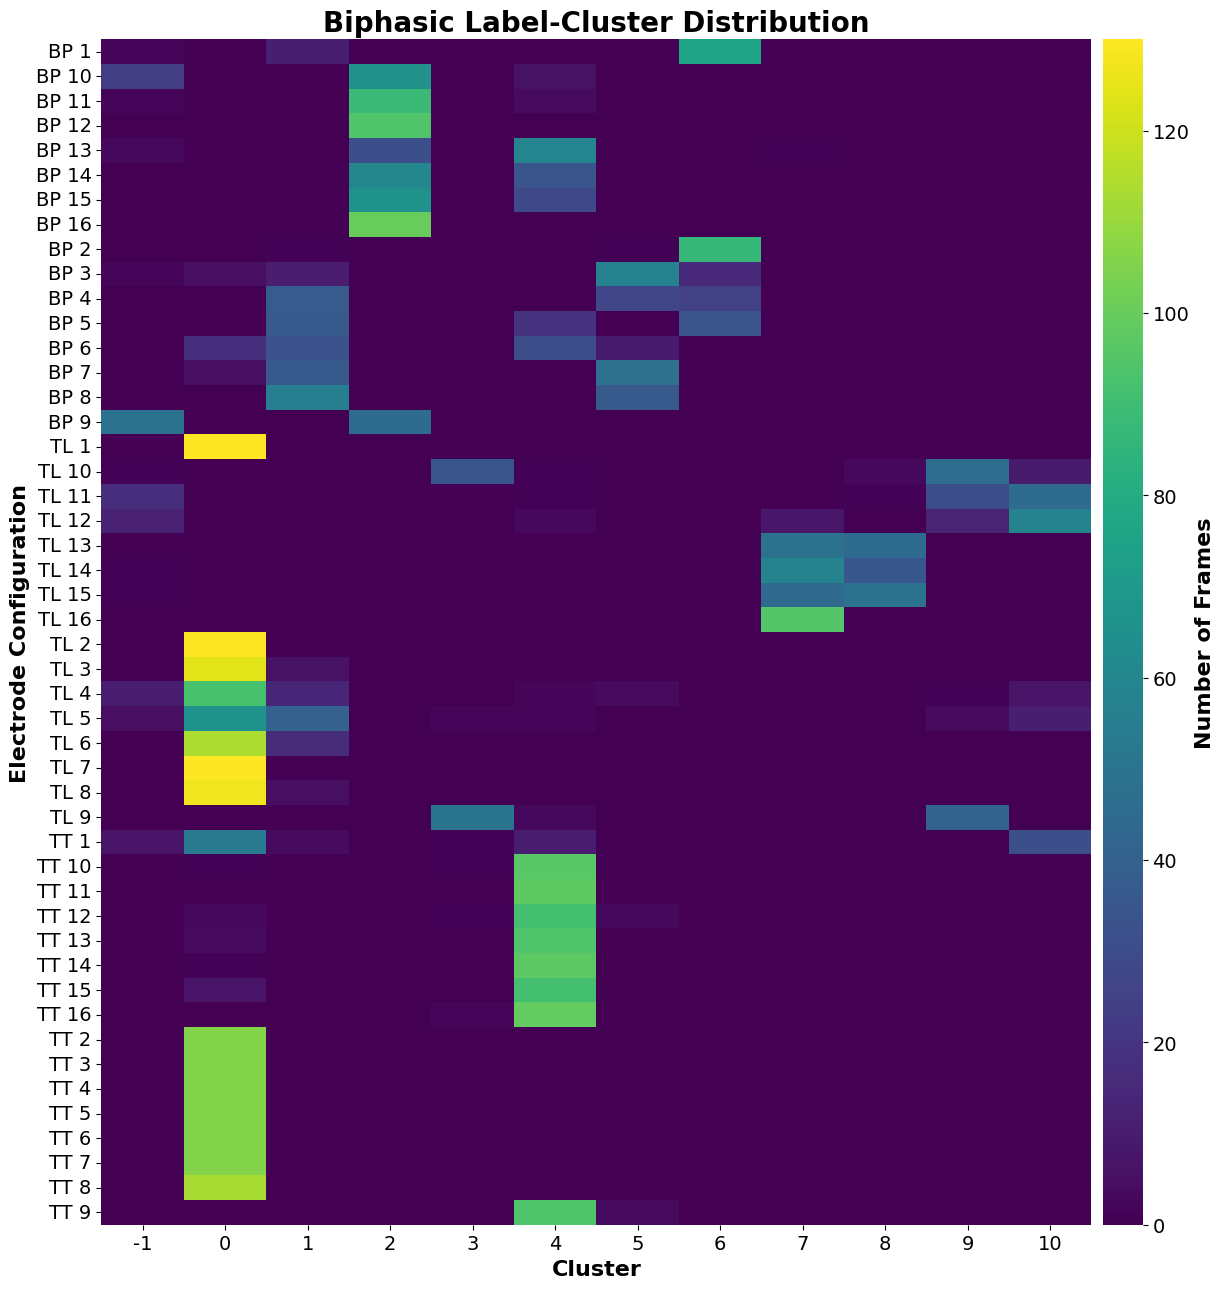

In [ ]:
# Static visualization of the UMAP-HDBSCAN Clustering Results with Actual Config Labels

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import adjusted_mutual_info_score
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
import pandas as pd

def create_cluster_visualization(df, figsize=(13, 13)):
    """
    Create UMAP 2D visualization with non-overlapping labels using matplotlib.
    """
    # Calculate AMI score
    ami_score = adjusted_mutual_info_score(
        df['Actual Label (Configuration)'],
        df['Cluster']
    )
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create scatter plot with a colormap
    num_clusters = df['Cluster'].nunique()
    base_colors = sns.color_palette("tab20", 20).as_hex()
    additional_colors = sns.color_palette("tab20c", 4).as_hex()
    all_colors = base_colors + additional_colors
    cmap = ListedColormap(all_colors[:num_clusters])

    scatter = ax.scatter(df['UMAP1'], df['UMAP2'], 
                         c=df['Cluster'], 
                         cmap=cmap,
                         alpha=0.6,
                         s=50)
    
    # Add colorbar
    colorbar = plt.colorbar(scatter, ax=ax, label='Cluster', pad=0.01, aspect=30, shrink=1)
    colorbar.ax.tick_params(labelsize=14)
    colorbar.set_label('Cluster', fontsize=16, fontweight='bold')
    
    # Calculate centroids for each actual label
    centroids = df.groupby('Actual Label (Configuration)')[['UMAP1', 'UMAP2']].mean()
    
    # Prepare texts for labels (show all configs)
    texts = []
    for label, centroid in centroids.iterrows():
        # Find closest point to centroid
        distances = distance.cdist([centroid], df[['UMAP1', 'UMAP2']])
        closest_point_index = np.argmin(distances)
        point = df.iloc[closest_point_index]
        text = plt.text(point['UMAP1'], point['UMAP2'], 
                        str(label),
                        fontsize=13,
                        fontweight='bold',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1),
                        ha='center',
                        va='center',
                        zorder=5)
        texts.append(text)
    
    # Adjust text positions to prevent overlap
    adjust_text(texts,
               expand_points=(2, 2),
               arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    
    # Set title and labels
    ax.set_title(f'Biphasic UMAP Visualization with HDBSCAN Clusters\nAMI Score: {ami_score:.3f}',
                 fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel('UMAP1', fontsize=16, fontweight='bold')
    ax.set_ylabel('UMAP2', fontsize=16, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    plt.tight_layout()
    return plt.gcf()

def create_analysis_plots(df, figsize=(13, 13)):
    """
    Create a confusion matrix heatmap of Actual Config vs. Cluster.
    """
    fig, ax2 = plt.subplots(figsize=figsize)
    conf_mat = pd.crosstab(df['Actual Label (Configuration)'], df['Cluster'])
    heatmap = sns.heatmap(conf_mat, cmap='viridis', ax=ax2, cbar_kws={'pad': 0.01, 'aspect': 30, 'shrink': 1})
    ax2.set_title('Biphasic Label-Cluster Distribution', fontsize=20, fontweight='bold')
    ax2.set_xlabel('Cluster', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Electrode Configuration', fontsize=16, fontweight='bold')
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=14)
    colorbar.set_label('Number of Frames', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

def visualize_clusters(df, main_fig_filename=None, analysis_fig_filename=None):
    """
    Create and display all visualizations.
    Optionally save figures if filenames are provided.
    """
    main_fig = create_cluster_visualization(df)
    analysis_fig = create_analysis_plots(df)
    # Save as TIFF if filenames are provided
    if main_fig_filename:
        main_fig.savefig(main_fig_filename, dpi=600, format='tiff')
    if analysis_fig_filename:
        analysis_fig.savefig(analysis_fig_filename, dpi=600, format='tiff')
    return main_fig, analysis_fig

# Usage (will prompt user for filenames):
main_fig_filename = input("Enter filename for main UMAP visualization (or leave blank to skip saving): ").strip()
analysis_fig_filename = input("Enter filename for analysis plot (or leave blank to skip saving): ").strip()
main_fig_filename = main_fig_filename if main_fig_filename else None
analysis_fig_filename = analysis_fig_filename if analysis_fig_filename else None

main_fig, analysis_fig = visualize_clusters(df_biphasic_12d_umap_hdbscan, main_fig_filename, analysis_fig_filename)
plt.show()

## TIS Trial (Batch 12g)

In [12]:
## For Batch 12g (TIS)

x_df_batch12g, y_df_batch12g, df_batch12g = process_file('/Users/joshwoah/Documents/University of Toronto/Postdoc Research/GitHub Postdoc/After tracking results/batch_12_csv/Batch 12g_(sideway_csv)/TIS Sweep 2-1726881367DLC_resnet50_batch_12_sweep_longOct6shuffle2_150000_filtered.csv')

In [13]:
import numpy as np
import pandas as pd

def calculate_euclidean_distances_per_row(x_df, y_df):
    distances = pd.DataFrame(index=x_df.index)
    for col in x_df.columns:
        y_col = col.replace(' x', ' y')
        if y_col in y_df.columns:
            distances[col.replace(' x', '')] = np.sqrt((x_df[col] - y_df[y_col]) ** 2)
    return distances

# Calculate the Euclidean distances per row
df_batch12g_disp = calculate_euclidean_distances_per_row(x_df_batch12g, y_df_batch12g)

# Print the distances per row
print(df_batch12g_disp)

            Hip      Knee     Ankle  Heel (ventral)  Instep (dorsal)  \
0      0.041333  0.250663  0.243775        0.116155         0.409222   
1      0.596553  0.264725  0.243775        0.115420         0.409845   
2      0.596601  0.268658  0.243571        0.115087         0.409496   
3      0.596833  0.269067  0.243752        0.114528         0.409216   
4      0.596944  0.273376  0.243752        0.114506         0.409216   
...         ...       ...       ...             ...              ...   
77330  0.122295  0.007074  0.051061        0.097642         0.144629   
77331  0.122434  0.007074  0.051061        0.098283         0.145398   
77332  0.122465  0.000211  0.049281        0.098318         0.146209   
77333  0.122680  0.001455  0.049281        0.098318         0.146209   
77334  0.122584  0.003133  0.048334        0.098414         0.145470   

       Toe 1 (Proximal Thumb)      Toe2  Toe 3 (Middle)      Toe4  \
0                    0.591373  0.598705        0.232988  0.418042 

In [14]:
# Add Actual Config labels to the TIS DataFrame
df_batch12g_disp['Actual Label (Configuration)'] = df_batch12g_disp.index // 600

# Print the resulting dataframe
print(df_batch12g_disp)
print(df_batch12g_disp.describe())


            Hip      Knee     Ankle  Heel (ventral)  Instep (dorsal)  \
0      0.041333  0.250663  0.243775        0.116155         0.409222   
1      0.596553  0.264725  0.243775        0.115420         0.409845   
2      0.596601  0.268658  0.243571        0.115087         0.409496   
3      0.596833  0.269067  0.243752        0.114528         0.409216   
4      0.596944  0.273376  0.243752        0.114506         0.409216   
...         ...       ...       ...             ...              ...   
77330  0.122295  0.007074  0.051061        0.097642         0.144629   
77331  0.122434  0.007074  0.051061        0.098283         0.145398   
77332  0.122465  0.000211  0.049281        0.098318         0.146209   
77333  0.122680  0.001455  0.049281        0.098318         0.146209   
77334  0.122584  0.003133  0.048334        0.098414         0.145470   

       Toe 1 (Proximal Thumb)      Toe2  Toe 3 (Middle)      Toe4  \
0                    0.591373  0.598705        0.232988  0.418042 

In [19]:
## UMAP and HDBSCAN with Bayesian Optimization

import umap
import hdbscan
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

# Define the search space for the parameters
space = [
    Integer(5, 200, name='n_neighbors'),
    Real(0.0, 1.0, name='min_dist'),
    Integer(2, 128, name='min_cluster_size'),
    Integer(5, 300, name='min_samples'),
    Real(0.0, 1.0, name='cluster_selection_epsilon')
]

# Define the objective function
@use_named_args(space)
def objective(**params):
    # Perform UMAP dimensionality reduction
    umap_reducer = umap.UMAP(n_neighbors=params['n_neighbors'], min_dist=params['min_dist'], n_components=3, random_state=42)
    umap_embedding = umap_reducer.fit_transform(df_batch12g_disp.drop(columns=['Actual Label (Configuration)']))

    # Perform HDBSCAN clustering
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=params['min_cluster_size'], min_samples=params['min_samples'], cluster_selection_epsilon=params['cluster_selection_epsilon'])
    hdbscan_labels = hdbscan_clusterer.fit_predict(umap_embedding)
    
    # Calculate silhouette score and adjusted mutual information
    if len(set(hdbscan_labels)) > 1:  # Ensure there is more than one cluster
        silhouette_avg = silhouette_score(umap_embedding, hdbscan_labels)
        ami = adjusted_mutual_info_score(df_batch12g_disp['Actual Label (Configuration)'], hdbscan_labels)
        # Combine the scores with a heavier weight on AMI
        score = silhouette_avg + 2 * ami
    else:
        score = -np.inf  # Penalize if only one cluster is found
    
    return -score  # Minimize the negative score

# Perform Bayesian optimization
res = gp_minimize(objective, space, n_calls=50, random_state=42)

# Print the best parameters and the corresponding score
print("Best parameters:")
print(f"n_neighbors: {res.x[0]}")
print(f"min_dist: {res.x[1]}")
print(f"min_cluster_size: {res.x[2]}")
print(f"min_samples: {res.x[3]}")
print(f"cluster_selection_epsilon: {res.x[4]}")
print(f"Best score: {-res.fun}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/um

Best parameters:
n_neighbors: 24
min_dist: 0.04105602761439314
min_cluster_size: 38
min_samples: 43
cluster_selection_epsilon: 0.3481134171479973
Best score: 1.8828978761294513


In [15]:
# Perform UMAP with the best parameters

import umap
map_reducer = umap.UMAP(n_neighbors=24, min_dist=0.04105602761439314, n_components=3, random_state=42)
umap_embedding = map_reducer.fit_transform(df_batch12g_disp.drop(columns=['Actual Label (Configuration)']))

# Perform HDBSCAN clustering with the best parameters
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=38,
    min_samples=43,
    cluster_selection_epsilon=0.3481134171479973
)
hdbscan_labels = hdbscan_clusterer.fit_predict(umap_embedding)

# Add the UMAP embedding HDBSCAN cluster, and Actual Config labels to the DataFrame
df_TIS_12g_umap_hdbscan = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_TIS_12g_umap_hdbscan['Cluster'] = hdbscan_labels
df_TIS_12g_umap_hdbscan['Actual Label (Configuration)'] = df_batch12g_disp['Actual Label (Configuration)'].values

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


22 [-0.13633708  0.01512042]
63 [ 0.83952545 -0.02603131]
74 [ 0.56215388 -0.87984874]
97 [0.76387697 0.0807304 ]
112 [ 0.17989989 -0.15010391]
114 [-0.49981643  0.56349244]


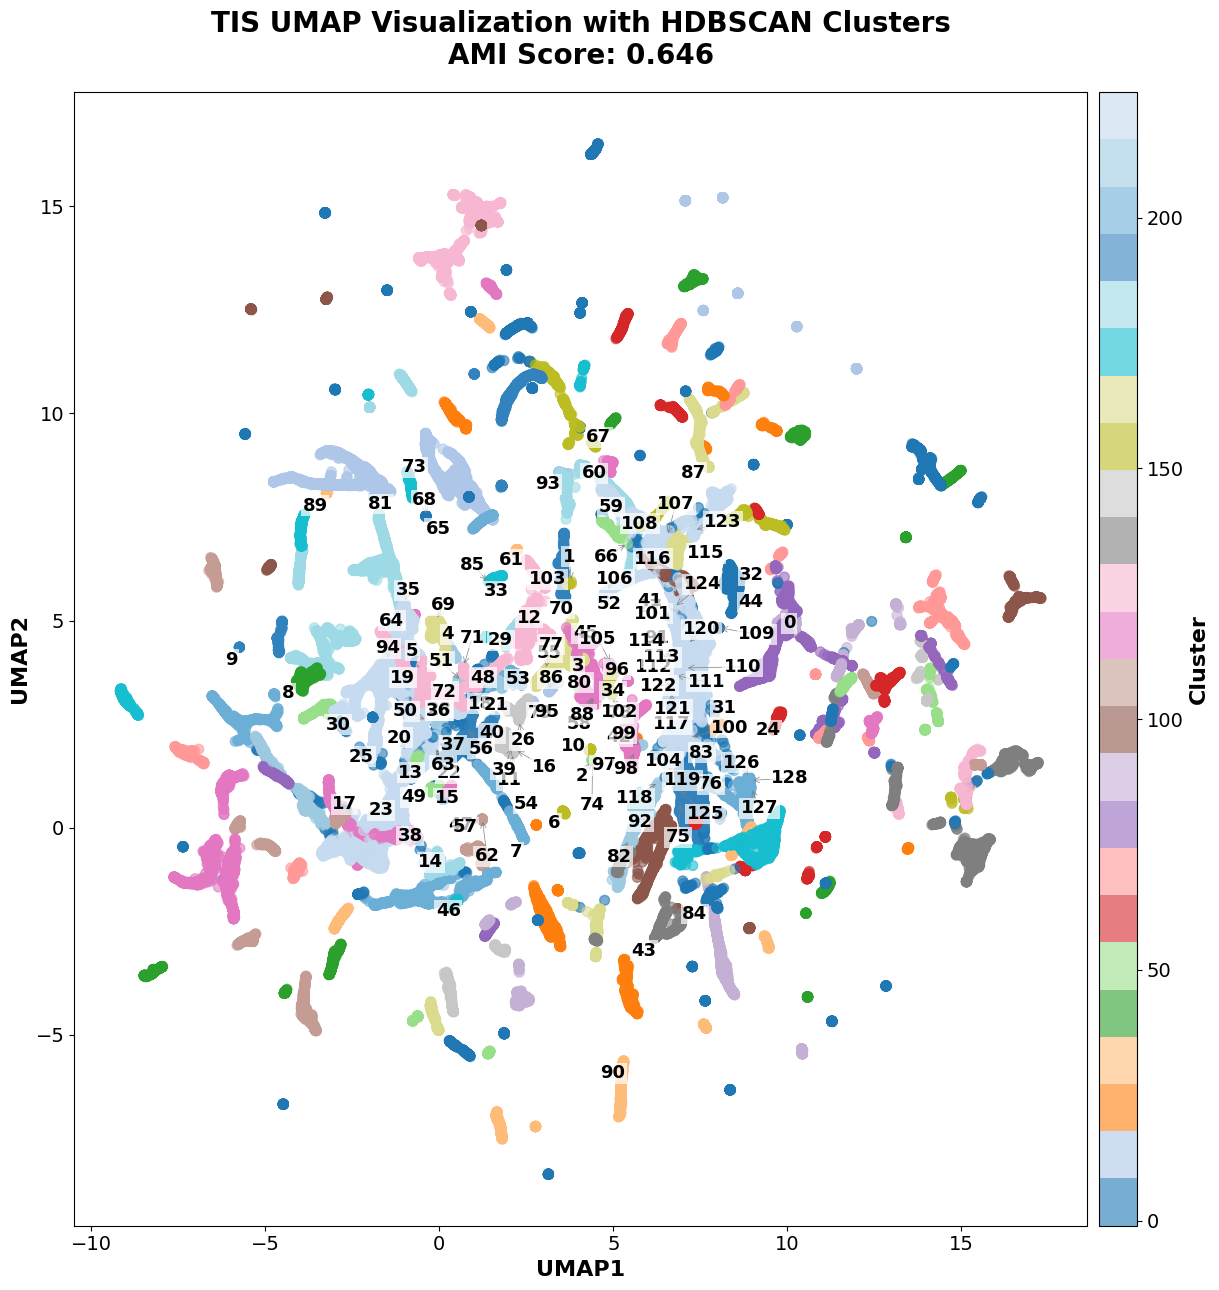

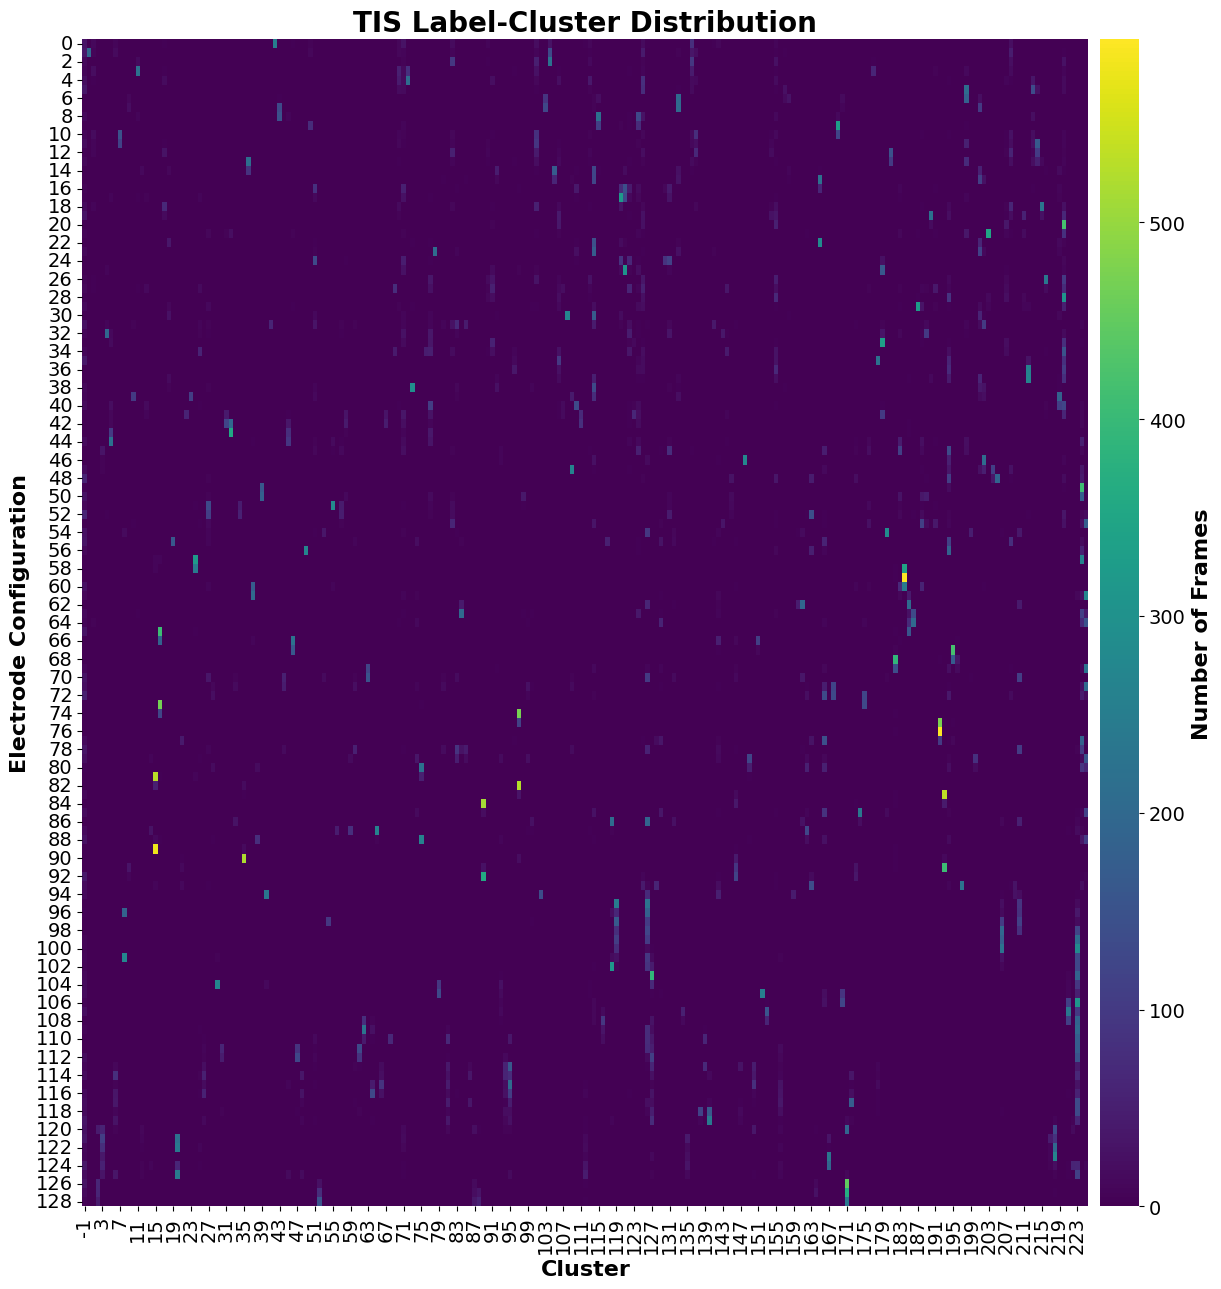

In [16]:
# Static visualization of the UMAP-HDBSCAN Clustering Results with Actual Config Labels

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import adjusted_mutual_info_score
from matplotlib.colors import ListedColormap
from adjustText import adjust_text
import pandas as pd

def create_cluster_visualization(df, figsize=(13, 13)):
    """
    Create UMAP 2D visualization with non-overlapping labels using matplotlib.
    """
    # Calculate AMI score
    ami_score = adjusted_mutual_info_score(
        df['Actual Label (Configuration)'],
        df['Cluster']
    )
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create scatter plot with a colormap
    num_clusters = df['Cluster'].nunique()
    base_colors = sns.color_palette("tab20", 20).as_hex()
    additional_colors = sns.color_palette("tab20c", 4).as_hex()
    all_colors = base_colors + additional_colors
    cmap = ListedColormap(all_colors[:num_clusters])

    scatter = ax.scatter(df['UMAP1'], df['UMAP2'], 
                         c=df['Cluster'], 
                         cmap=cmap,
                         alpha=0.6,
                         s=50)
    
    # Add colorbar
    colorbar = plt.colorbar(scatter, ax=ax, label='Cluster', pad=0.01, aspect=30, shrink=1)
    colorbar.ax.tick_params(labelsize=14)
    colorbar.set_label('Cluster', fontsize=16, fontweight='bold')
    
    # Calculate centroids for each actual label
    centroids = df.groupby('Actual Label (Configuration)')[['UMAP1', 'UMAP2']].mean()
    
    # Prepare texts for labels (show all configs)
    texts = []
    for label, centroid in centroids.iterrows():
        # Find closest point to centroid
        distances = distance.cdist([centroid], df[['UMAP1', 'UMAP2']])
        closest_point_index = np.argmin(distances)
        point = df.iloc[closest_point_index]
        text = plt.text(point['UMAP1'], point['UMAP2'], 
                        str(label),
                        fontsize=13,
                        fontweight='bold',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1),
                        ha='center',
                        va='center',
                        zorder=5)
        texts.append(text)
    
    # Adjust text positions to prevent overlap
    adjust_text(texts,
               expand_points=(2, 2),
               arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    
    # Set title and labels
    ax.set_title(f'TIS UMAP Visualization with HDBSCAN Clusters\nAMI Score: {ami_score:.3f}',
                 fontsize=20, fontweight='bold', pad=20)
    ax.set_xlabel('UMAP1', fontsize=16, fontweight='bold')
    ax.set_ylabel('UMAP2', fontsize=16, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    plt.tight_layout()
    return plt.gcf()

def create_analysis_plots(df, figsize=(13, 13)):
    """
    Create a confusion matrix heatmap of Actual Config vs. Cluster.
    """
    fig, ax2 = plt.subplots(figsize=figsize)
    conf_mat = pd.crosstab(df['Actual Label (Configuration)'], df['Cluster'])
    heatmap = sns.heatmap(conf_mat, cmap='viridis', ax=ax2, cbar_kws={'pad': 0.01, 'aspect': 30, 'shrink': 1})
    ax2.set_title('TIS Label-Cluster Distribution', fontsize=20, fontweight='bold')
    ax2.set_xlabel('Cluster', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Electrode Configuration', fontsize=16, fontweight='bold')
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=14)
    colorbar.set_label('Number of Frames', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

def visualize_clusters(df, main_fig_filename=None, analysis_fig_filename=None):
    """
    Create and display all visualizations.
    Optionally save figures if filenames are provided.
    """
    main_fig = create_cluster_visualization(df)
    analysis_fig = create_analysis_plots(df)
    # Save as TIFF if filenames are provided
    if main_fig_filename:
        main_fig.savefig(main_fig_filename, dpi=600, format='tiff')
    if analysis_fig_filename:
        analysis_fig.savefig(analysis_fig_filename, dpi=600, format='tiff')
    return main_fig, analysis_fig

# Usage (will prompt user for filenames):
main_fig_filename = input("Enter filename for main UMAP visualization (or leave blank to skip saving): ").strip()
analysis_fig_filename = input("Enter filename for analysis plot (or leave blank to skip saving): ").strip()
main_fig_filename = main_fig_filename if main_fig_filename else None
analysis_fig_filename = analysis_fig_filename if analysis_fig_filename else None

main_fig, analysis_fig = visualize_clusters(df_TIS_12g_umap_hdbscan, main_fig_filename, analysis_fig_filename)
plt.show()

## Try other hyperparameters for TIS


In [17]:
import umap
map_reducer = umap.UMAP(n_neighbors=177, min_dist=0, n_components=3, random_state=42)
umap_embedding = map_reducer.fit_transform(df_batch12g_disp.drop(columns=['Actual Label (Configuration)']))

# Perform HDBSCAN clustering with the best parameters
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=128,
    min_samples=300,
    cluster_selection_epsilon=0.1
)
hdbscan_labels = hdbscan_clusterer.fit_predict(umap_embedding)

# Add the UMAP embedding HDBSCAN cluster, and Actual Config labels to the DataFrame
df_TIS_12g_umap_hdbscan = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_TIS_12g_umap_hdbscan['Cluster'] = hdbscan_labels
df_TIS_12g_umap_hdbscan['Actual Label (Configuration)'] = df_batch12g_disp['Actual Label (Configuration)'].values

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


43 [-0.40286578  0.00643498]
126 [ 0.22673904 -0.14593571]
42 [ 0.67674301 -0.50512547]
77 [ 0.40830084 -0.95229592]
113 [ 0.73742343 -0.29050741]
114 [-0.93885969  0.10188009]
115 [-0.03589332 -0.76669844]


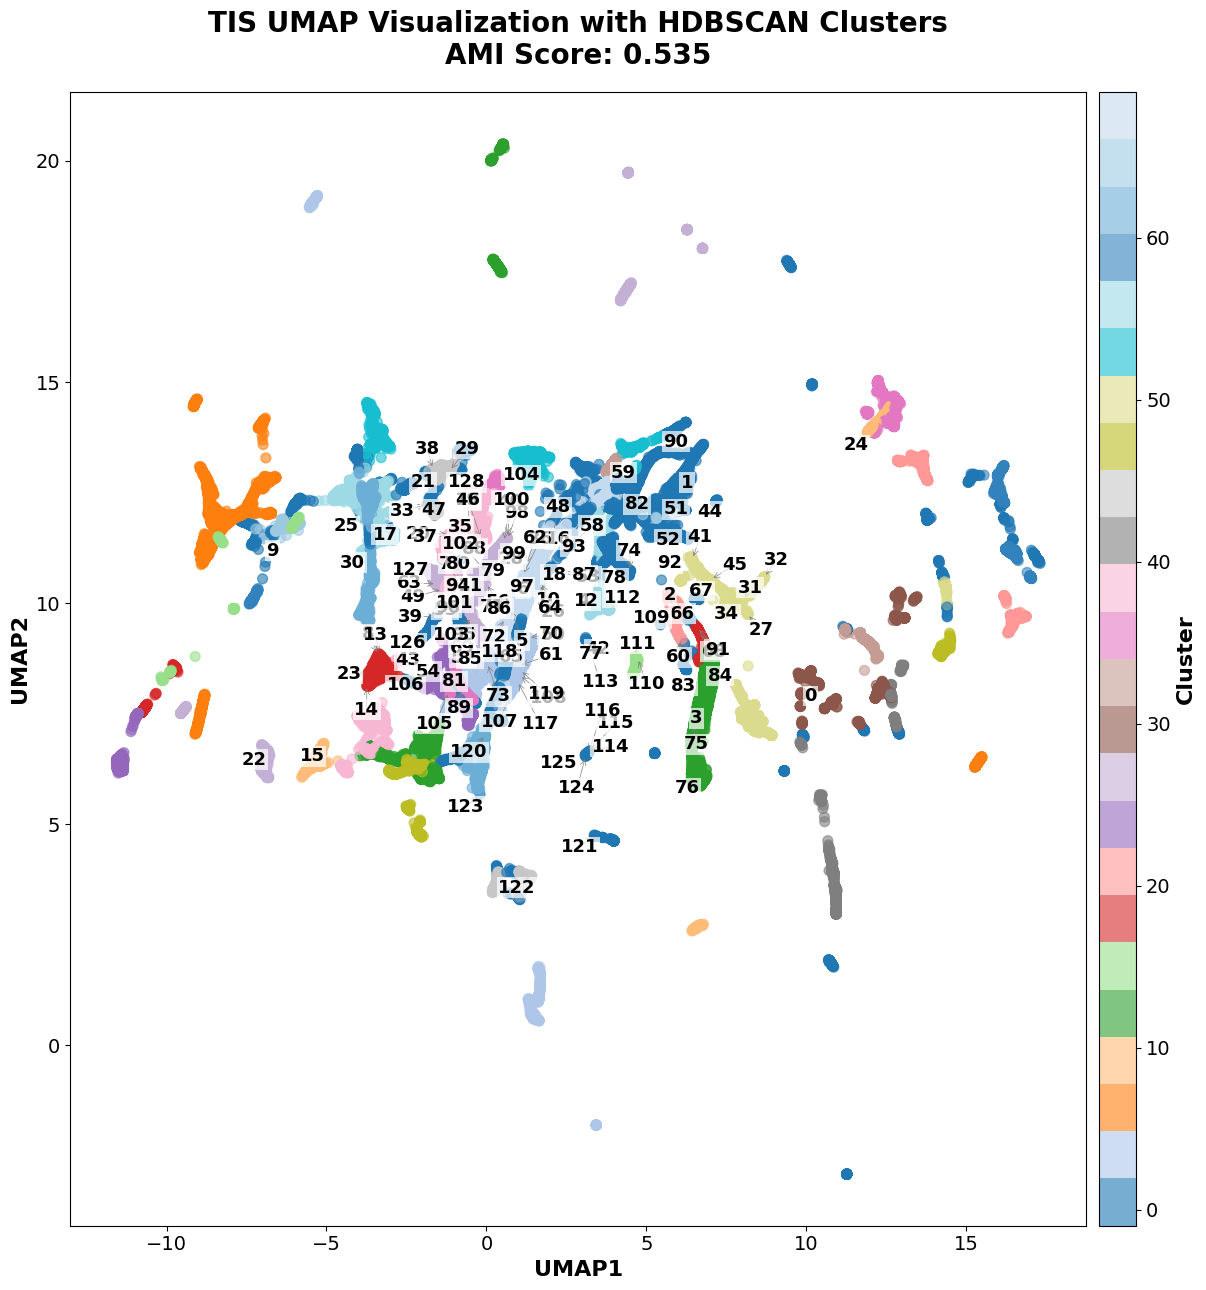

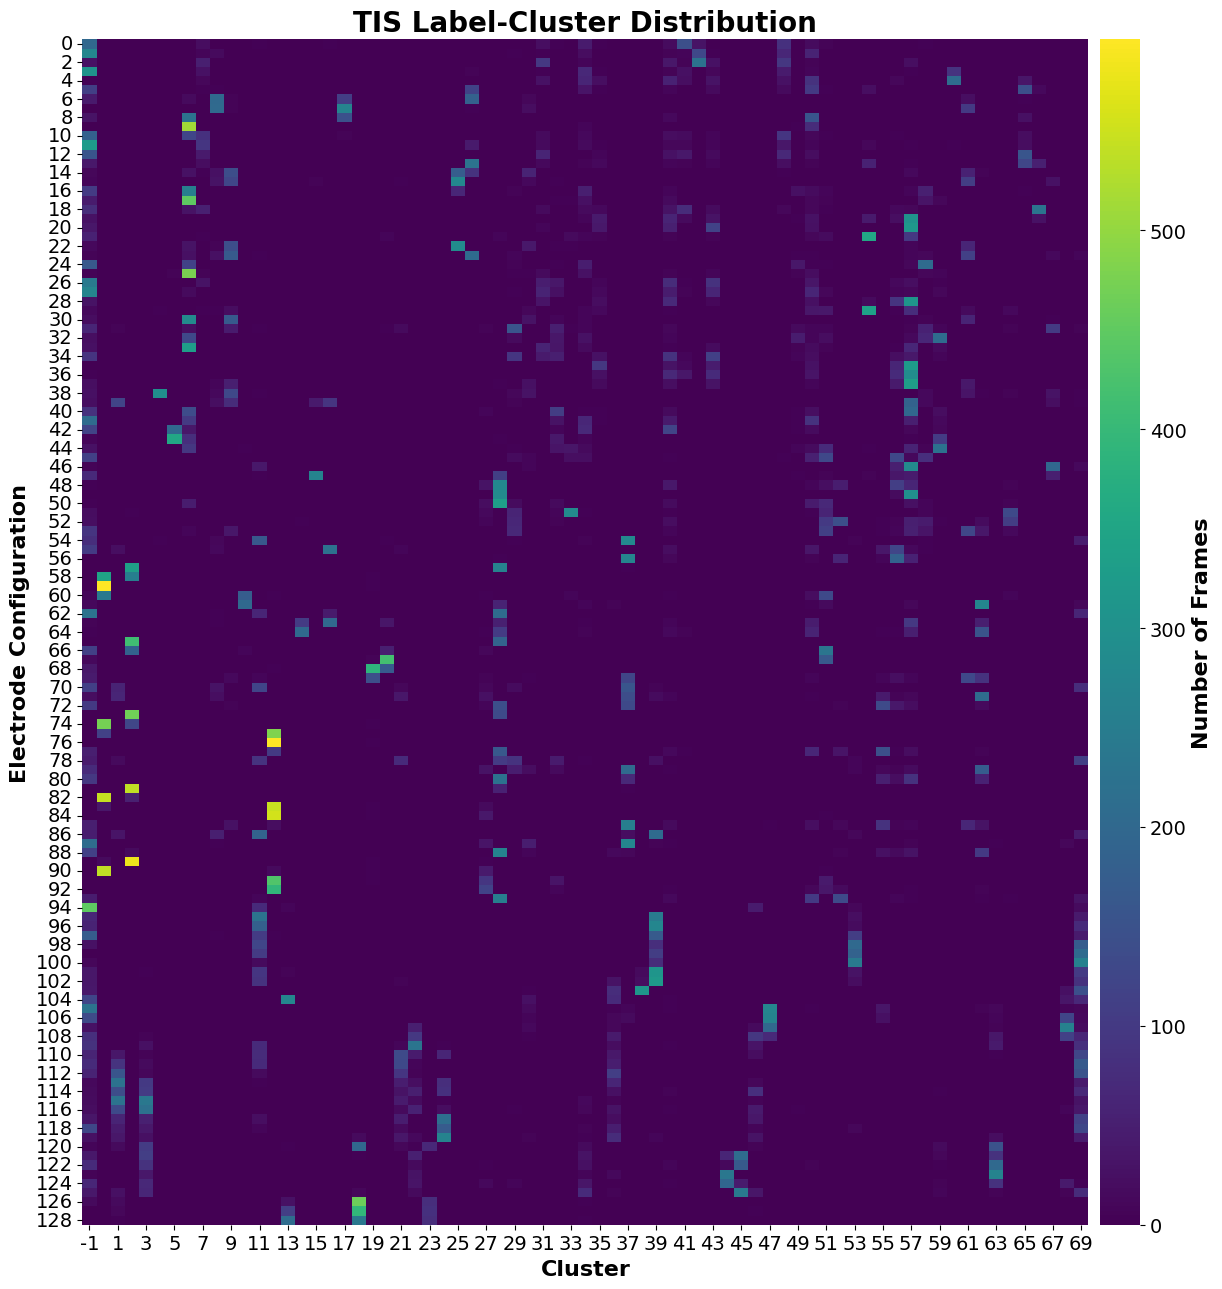

In [18]:
# Visualize clusters with the new parameters
main_fig_filename = input("Enter filename for main UMAP visualization (or leave blank to skip saving): ").strip()
analysis_fig_filename = input("Enter filename for analysis plot (or leave blank to skip saving): ").strip()
main_fig_filename = main_fig_filename if main_fig_filename else None
analysis_fig_filename = analysis_fig_filename if analysis_fig_filename else None

main_fig, analysis_fig = visualize_clusters(df_TIS_12g_umap_hdbscan, main_fig_filename, analysis_fig_filename)
plt.show()

In [19]:
config_counts = df_batch12g_disp['Actual Label (Configuration)'].value_counts().sort_index()
print(f"Number of unique values: {config_counts.shape[0]}")
print("Rows per unique value:")
print(config_counts)

Number of unique values: 129
Rows per unique value:
Actual Label (Configuration)
0      600
1      600
2      600
3      600
4      600
      ... 
124    600
125    600
126    600
127    600
128    535
Name: count, Length: 129, dtype: int64


In [20]:
# Perform HDBSCAN clustering with hyperparameter tuning (grid search) for TIS (Batch 12g)

import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
import pandas as pd
import numpy as np

# True labels for evaluation (using your config labels)
true_labels = df_batch12g_disp['Actual Label (Configuration)'].values

# Hyperparameter grids to try (recommended ranges)
min_cluster_sizes = [100, 300, 600]
min_samples_list = [10, 50, 100]
cluster_selection_epsilons = [0.0, 0.2, 0.5]

results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        for epsilon in cluster_selection_epsilons:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                cluster_selection_epsilon=epsilon
            )
            labels = clusterer.fit_predict(umap_embedding)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            # Only score if more than 1 cluster and not all noise
            if n_clusters > 1 and np.any(labels != -1):
                sil = silhouette_score(umap_embedding[labels != -1], labels[labels != -1])
                ari = adjusted_rand_score(true_labels[labels != -1], labels[labels != -1])
                ami = adjusted_mutual_info_score(true_labels[labels != -1], labels[labels != -1])
            else:
                sil, ari, ami = np.nan, np.nan, np.nan
            results.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'epsilon': epsilon,
                'n_clusters': n_clusters,
                'silhouette': sil,
                'ARI': ari,
                'AMI': ami
            })

# Convert results to DataFrame and sort by AMI, silhouette, and closeness to number of stimulations
n_stim = len(np.unique(true_labels))
results_df = pd.DataFrame(results)
results_df['cluster_diff'] = (results_df['n_clusters'] - n_stim).abs()
results_df = results_df.sort_values(['AMI', 'silhouette', 'cluster_diff'], ascending=[False, False, True])

print(results_df[['min_cluster_size', 'min_samples', 'epsilon', 'n_clusters', 'silhouette', 'ARI', 'AMI']].head(10))

    min_cluster_size  min_samples  epsilon  n_clusters  silhouette       ARI  \
3                100           50      0.0         253    0.734804  0.304132   
0                100           10      0.0         270    0.691605  0.291511   
6                100          100      0.0         205    0.749187  0.263365   
7                100          100      0.2         163    0.704432  0.242114   
4                100           50      0.2         157    0.639152  0.240036   
9                300           10      0.0         106    0.628461  0.246983   
12               300           50      0.0          99    0.620887  0.205239   
13               300           50      0.2          93    0.618668  0.203357   
15               300          100      0.0          89    0.659175  0.209953   
16               300          100      0.2          89    0.659175  0.209953   

         AMI  
3   0.681215  
0   0.675220  
6   0.673404  
7   0.649095  
4   0.637809  
9   0.625045  
12  0.612791  

In [ ]:
# Perform UMAP and HDBSCAN clustering with the chosen  parameters

import umap
map_reducer = umap.UMAP(n_neighbors=100, min_dist=0, n_components=3, random_state=42)
umap_embedding = map_reducer.fit_transform(df_batch12g_disp.drop(columns=['Actual Label (Configuration)']))

import hdbscan
hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=300,
    min_samples=200,
    cluster_selection_epsilon=0.3
)
hdbscan_labels = hdbscan_clusterer.fit_predict(umap_embedding)

# Add the UMAP embedding HDBSCAN cluster, and Actual Config labels to the DataFrame
df_TIS_12g_umap_hdbscan = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_TIS_12g_umap_hdbscan['Cluster'] = hdbscan_labels
df_TIS_12g_umap_hdbscan['Actual Label (Configuration)'] = df_batch12g_disp['Actual Label (Configuration)'].values

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


15 [-0.85407151 -0.39605241]
22 [-0.59058225  0.6795299 ]
96 [-0.5710988  -0.83520894]
101 [ 0.48297866 -0.05742763]
102 [0.47977031 0.36727215]
103 [-0.14882036  0.7505403 ]
94 [-0.49091765 -0.14206858]
97 [-0.09953923 -0.16053367]
98 [ 0.20703637 -0.75007545]
99 [-0.63847177  0.54464514]
38 [0.45817005 0.41078548]
100 [ 0.09757293 -0.8810232 ]
7 [0.66936476 0.29751136]
104 [-0.8754786   0.84637987]
108 [-0.2785674 -0.4844984]
111 [-0.05558984 -0.02156303]
112 [0.92237098 0.25329712]
47 [-0.38686902 -0.04766023]
110 [0.8334509  0.53481046]
114 [0.85008278 0.30312506]
115 [-0.26192553 -0.92732636]
116 [-0.71643754 -0.81294206]
117 [ 0.62172816 -0.15185067]
113 [-0.53496733 -0.13529313]
118 [ 0.02027424 -0.68159602]
119 [ 0.94305991 -0.53530825]
127 [ 0.41262725 -0.84294687]
35 [ 0.94350198 -0.99782359]
44 [ 0.31412202 -0.96263751]
56 [-0.48586493 -0.34588489]
79 [-0.79898407  0.76019089]
124 [-0.30522939  0.89556226]
4 [ 0.65637206 -0.25483415]
19 [-0.42644261 -0.52633566]
20 [-0.10706

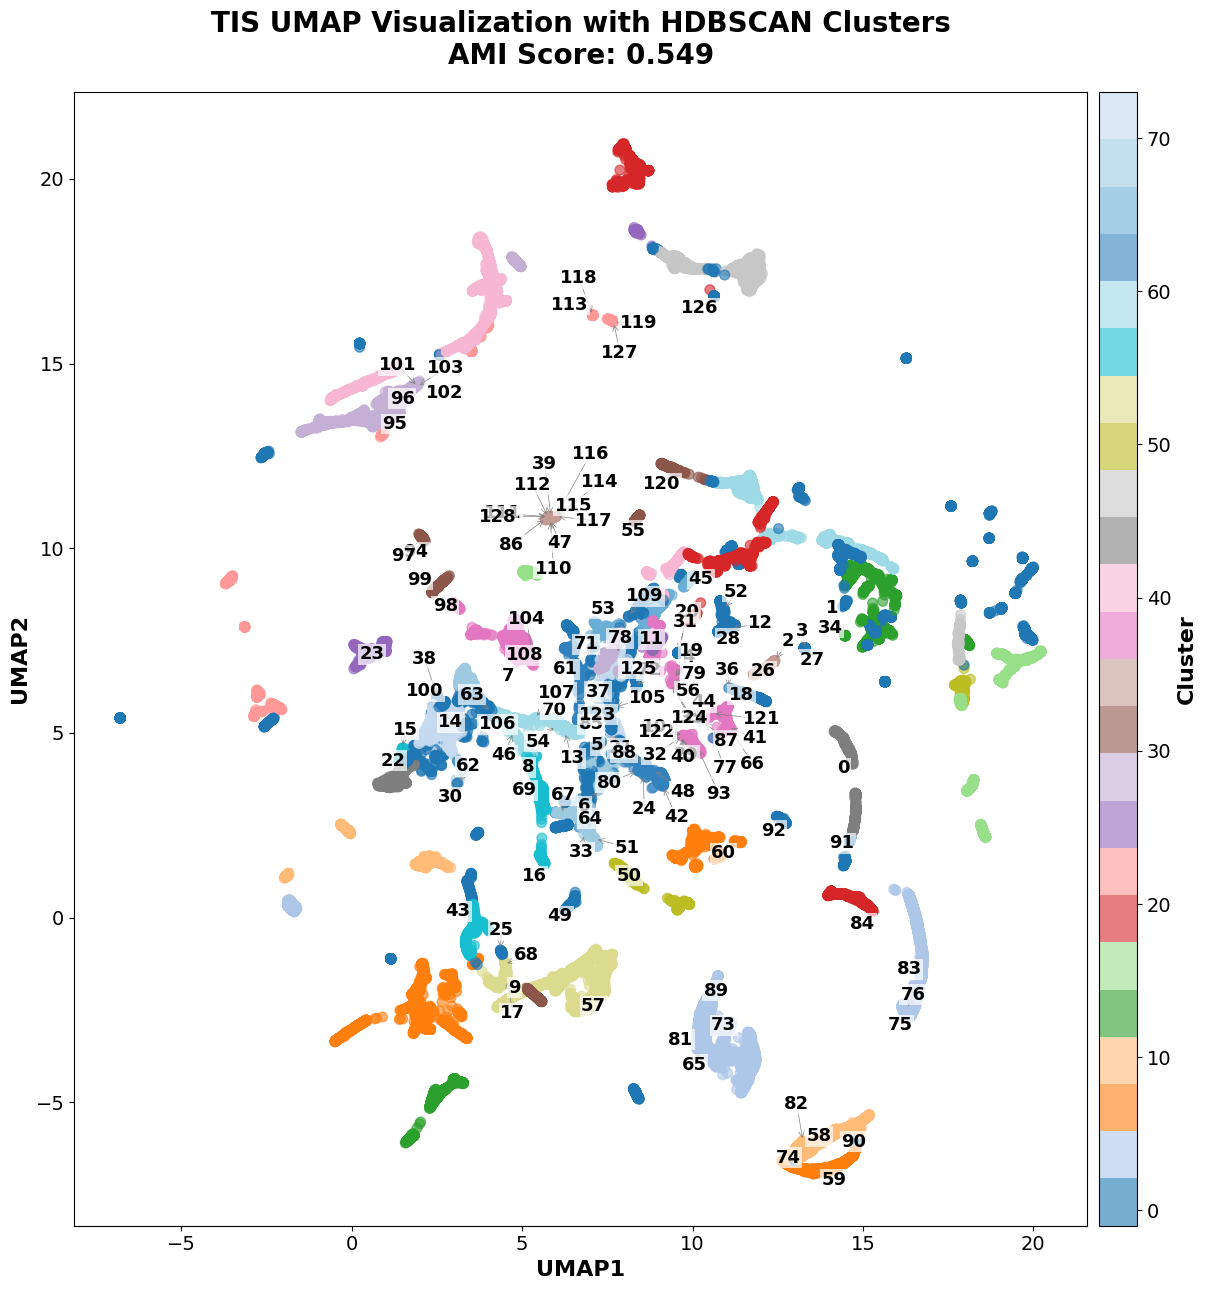

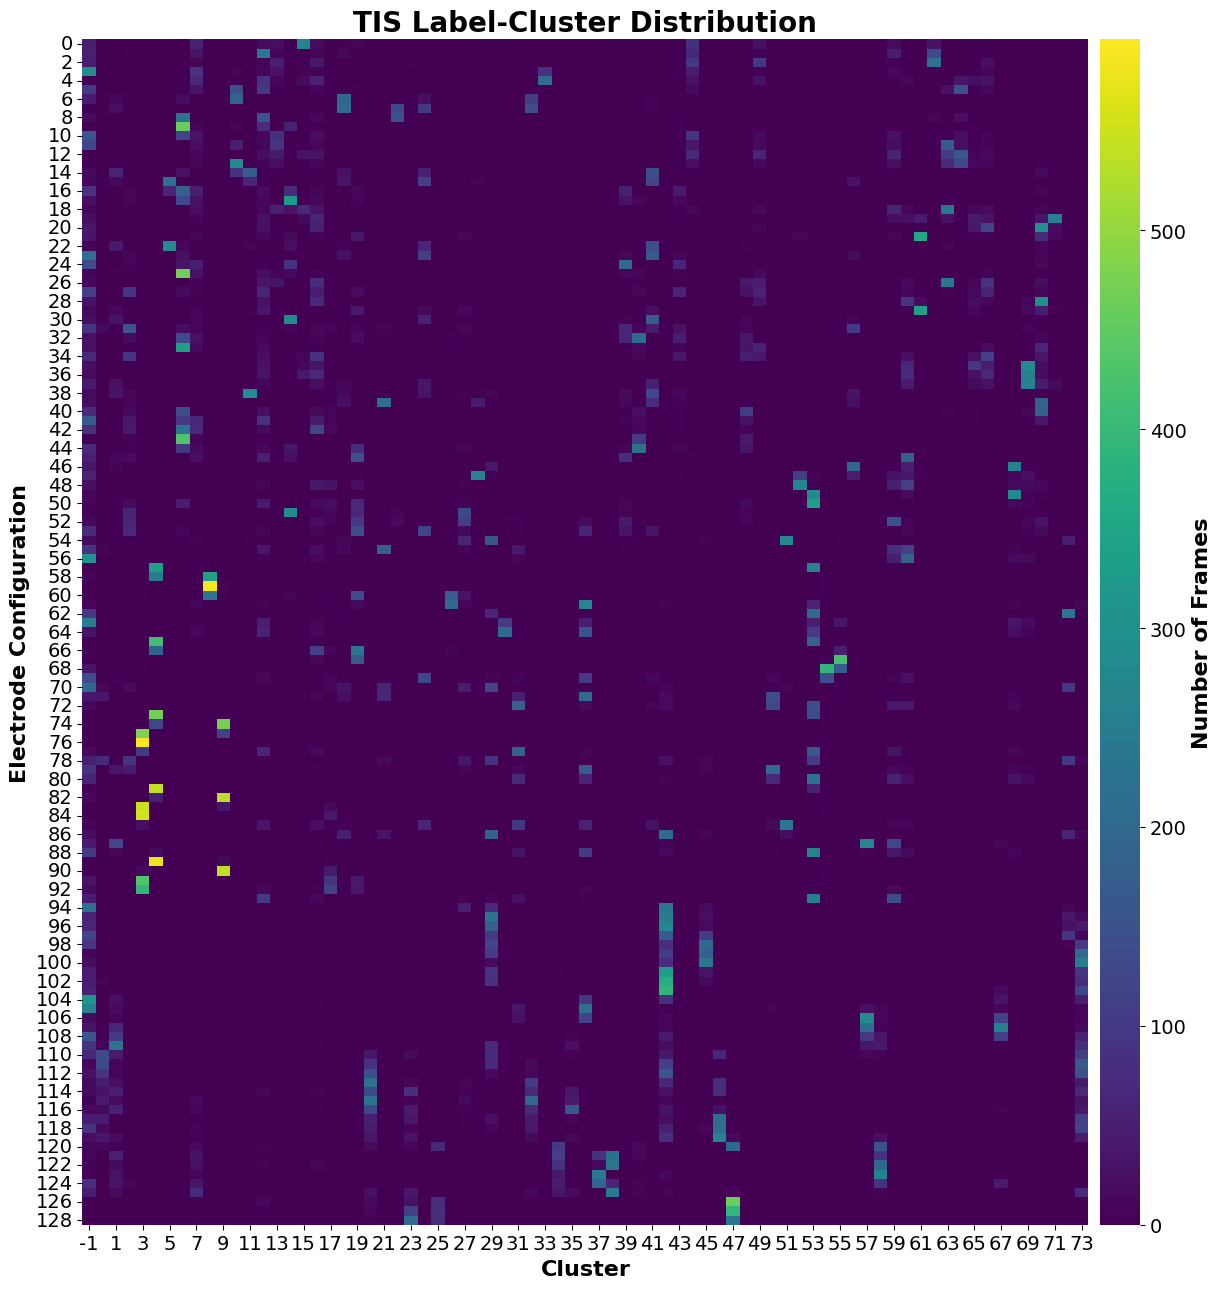

In [43]:
# Visualize clusters with the new parameters
main_fig_filename = input("Enter filename for main UMAP visualization (or leave blank to skip saving): ").strip()
analysis_fig_filename = input("Enter filename for analysis plot (or leave blank to skip saving): ").strip()
main_fig_filename = main_fig_filename if main_fig_filename else None
analysis_fig_filename = analysis_fig_filename if analysis_fig_filename else None

main_fig, analysis_fig = visualize_clusters(df_TIS_12g_umap_hdbscan, main_fig_filename, analysis_fig_filename)
plt.show()

In [44]:
n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
print(f"Number of clusters (excluding noise): {n_clusters}")

Number of clusters (excluding noise): 74


In [ ]:
## UMAP and HDBSCAN with Bayesian Optimization

import umap
import hdbscan
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

# Define the search space for the parameters
space = [
    Integer(5, 200, name='n_neighbors'),
    Real(0.0, 1.0, name='min_dist'),
    Integer(2, 128, name='min_cluster_size'),
    Integer(5, 300, name='min_samples'),
    Real(0.0, 1.0, name='cluster_selection_epsilon')
]

# Store all results
bayes_results = []

# Define the objective function
@use_named_args(space)
def objective(**params):
    # Perform UMAP dimensionality reduction
    umap_reducer = umap.UMAP(n_neighbors=params['n_neighbors'], min_dist=params['min_dist'], n_components=3, random_state=42)
    umap_embedding = umap_reducer.fit_transform(df_batch12g_disp.drop(columns=['Actual Label (Configuration)']))

    # Perform HDBSCAN clustering
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=params['min_cluster_size'], min_samples=params['min_samples'], cluster_selection_epsilon=params['cluster_selection_epsilon'])
    hdbscan_labels = hdbscan_clusterer.fit_predict(umap_embedding)
    
    # Calculate silhouette score and adjusted mutual information
    if len(set(hdbscan_labels)) > 1:  # Ensure there is more than one cluster
        silhouette_avg = silhouette_score(umap_embedding, hdbscan_labels)
        ami = adjusted_mutual_info_score(df_batch12g_disp['Actual Label (Configuration)'], hdbscan_labels)
        # Combine the scores with a heavier weight on AMI
        score = silhouette_avg + 2 * ami
    else:
        score = -np.inf  # Penalize if only one cluster is found
    
    # Save the parameters and scores
    bayes_results.append({
        'n_neighbors': params['n_neighbors'],
        'min_dist': params['min_dist'],
        'min_cluster_size': params['min_cluster_size'],
        'min_samples': params['min_samples'],
        'cluster_selection_epsilon': params['cluster_selection_epsilon'],
        'silhouette': silhouette_avg,
        'AMI': ami,
        'score': score
    })
    
    return -score  # Minimize the negative score

# Perform Bayesian optimization
res = gp_minimize(objective, space, n_calls=50, random_state=42)

# Print the best parameters and the corresponding score
print("Best parameters:")
print(f"n_neighbors: {res.x[0]}")
print(f"min_dist: {res.x[1]}")
print(f"min_cluster_size: {res.x[2]}")
print(f"min_samples: {res.x[3]}")
print(f"cluster_selection_epsilon: {res.x[4]}")
print(f"Best score: {-res.fun}")